In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import geopandas as gpd
import numpy as np
from shapely.geometry import box

from typing import Tuple, Dict, Any

In [2]:
def geojson_to_numpy_grid(
    geojson_file: str,
    grid_size: Tuple[int, int],
    feature_column: str,
    target_crs: str = "EPSG:3857"  # Web Mercator projection
) -> Tuple[np.ndarray, np.ndarray, Dict[Any, int]]:
    # Read the GeoJSON file
    gdf = gpd.read_file(geojson_file)

    # Reproject to target CRS
    gdf = gdf.to_crs(target_crs)

    # Get the total bounds of all geometries
    minx, miny, maxx, maxy = gdf.total_bounds

    # Create a fixed-size grid
    x = np.linspace(minx, maxx, grid_size[1] + 1)
    y = np.linspace(miny, maxy, grid_size[0] + 1)

    # Get unique categories and create a mapping to integers
    categories = gdf[feature_column].unique()
    category_to_int = {cat: i for i, cat in enumerate(categories)}

    # Initialize the 2D NumPy array with -1 (representing no data)
    grid = np.full(grid_size, -1, dtype=int)

    # Create a spatial index for faster intersection checks
    sindex = gdf.sindex

    # Pre-compute cell geometries
    cells = [box(x[j], y[i], x[j+1], y[i+1])
             for i in range(grid_size[0])
             for j in range(grid_size[1])]

    # Vectorized operations for intersection
    def process_cell(cell, possible_matches):
        if possible_matches.empty:
            return -1
        intersections = possible_matches.geometry.intersection(cell)
        intersection_areas = intersections.area
        largest_intersection_idx = intersection_areas.idxmax()
        category = possible_matches.loc[largest_intersection_idx, feature_column]
        return category_to_int[category]

    # Iterate through each cell in the grid
    for idx, cell in enumerate(cells):
        i, j = divmod(idx, grid_size[1])

        # Use the spatial index to find potential intersecting polygons
        possible_matches_index = list(sindex.intersection(cell.bounds))
        if not possible_matches_index:
            continue

        # Check for actual intersection and assign the feature value
        possible_matches = gdf.iloc[possible_matches_index]
        grid[i, j] = process_cell(cell, possible_matches)

    return grid, categories, category_to_int

In [3]:
def inspect_geojson(file_path):
    # Read the GeoJSON file
    gdf = gpd.read_file(file_path)

    # Get the column names
    columns = gdf.columns.tolist()

    # Print the column names
    print("Columns in the GeoJSON file:")
    for col in columns:
        print(f"- {col}")

    # Print a sample of the data
    print("\nSample data (first 5 rows):")
    print(gdf.head())

    # Print information about the GeoDataFrame
    print("\nDataFrame Info:")
    gdf.info()

Data Loading

In [55]:
cd drive/MyDrive/MinersAI/

[Errno 2] No such file or directory: 'drive/MyDrive/MinersAI/'
/content/drive/MyDrive/MinersAI


In [56]:
ls

BestValue_WholeRock_Majors.txt                                    Imputation.ipynb
CORNICES_CLIPPED.geojson                                          KMeansPCAExample.ipynb
DataDescribeCrossPlot.ipynb                                       Lithology_clipped.geojson
geoJSON_to_grid.ipynb                                             PlotlyJamboree.ipynb
geoquimica_cachoeiro_do_itapemirim_FL_cachoeiro_itapemirim_1997/  StructureData.ipynb


In [4]:
geojson_file = r"C:\Users\TyHow\MinersAI Dropbox\Product\Pilot Projects\Chile - Mantos Grandes\Geology\archivo_geologia-de-los-cuadrangulos-d-86-las-ramadas-carrizal-y-paso-rio-negro-region-de-coquimbo\MAP1\Digitizing\Finalized_Items\MAP1_geology.geojson"


In [5]:
inspect_geojson(geojson_file)

Columns in the GeoJSON file:
- lithology
- age
- lithology_description
- formation_name
- geometry

Sample data (first 5 rows):
  lithology              age  \
0      Pgdm  Upper Paleozoic   
1    PTrlc2   Lower Triassic   
2       Tso   Upper Tertiary   
3       Tso   Upper Tertiary   
4       Tso   Upper Tertiary   

                               lithology_description  formation_name  \
0                        Granodiorite with muscovite            None   
1  Intrusive rhyolitic porphyries that cut throug...  RIO LAS CUEVAS   
2                                          Appinites            None   
3                                          Appinites            None   
4                                          Appinites            None   

                                            geometry  
0  POLYGON ((-70.50227 -31.06560, -70.50212 -31.0...  
1  POLYGON ((-70.39328 -31.06926, -70.39318 -31.0...  
2  POLYGON ((-70.38891 -31.07528, -70.38854 -31.0...  
3  POLYGON ((-70.39776 -31

In [6]:
%%time
# Usage
grid_size = (100, 100)  # 200x200 grid
feature_column = 'lithology'  # Replace with your actual column name

result_grid, categories, category_mapping = geojson_to_numpy_grid(geojson_file, grid_size, feature_column)

CPU times: total: 12.8 s
Wall time: 13.1 s


In [7]:
# Print information about the result
print("Grid shape:", result_grid.shape)
print("Unique categories:", categories)
print("Category to integer mapping:", category_mapping)

# Print a sample of the grid
print("Sample of the grid (top-left 5x5):")
print(result_grid[:5, :5])

# Count occurrences of each category
unique, counts = np.unique(result_grid, return_counts=True)
print("\nCategory counts:")
for value, count in zip(unique, counts):
    if value != -1:
        category = [k for k, v in category_mapping.items() if v == value][0]
        print(f"{category} (value {value}): {count}")
    else:
        print(f"No data (value -1): {count}")

Grid shape: (100, 100)
Unique categories: ['Pgdm' 'PTrlc2' 'Tso' 'Qa' 'PTrlc1' 'Tsc' 'Tsm' 'Tsgd' 'Qm' 'Qt' 'Qd']
Category to integer mapping: {'Pgdm': 0, 'PTrlc2': 1, 'Tso': 2, 'Qa': 3, 'PTrlc1': 4, 'Tsc': 5, 'Tsm': 6, 'Tsgd': 7, 'Qm': 8, 'Qt': 9, 'Qd': 10}
Sample of the grid (top-left 5x5):
[[-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]

Category counts:
No data (value -1): 511
Pgdm (value 0): 100
PTrlc2 (value 1): 543
Tso (value 2): 60
Qa (value 3): 16
PTrlc1 (value 4): 4868
Tsc (value 5): 20
Tsm (value 6): 2678
Tsgd (value 7): 1104
Qm (value 8): 75
Qt (value 9): 18
Qd (value 10): 7


Timing Tests

In [8]:
import time

In [9]:
grid_sizes = [
        (2, 2), (4, 4), (8, 8), (16, 16), (32, 32),
        (64, 64), (128, 128), (256, 256), (512, 512), (1024, 1024)]

execution_times = []

for size in grid_sizes:
        start_time = time.time()
        geojson_to_numpy_grid(geojson_file, size, feature_column)
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)
        print(f"Grid size {size}: {execution_time:.2f} seconds")

Grid size (2, 2): 0.08 seconds
Grid size (4, 4): 0.09 seconds
Grid size (8, 8): 0.15 seconds
Grid size (16, 16): 0.40 seconds
Grid size (32, 32): 1.38 seconds
Grid size (64, 64): 5.23 seconds
Grid size (128, 128): 21.10 seconds
Grid size (256, 256): 83.86 seconds
Grid size (512, 512): 344.44 seconds
Grid size (1024, 1024): 1357.36 seconds


In [10]:
def plot_execution_times(grid_sizes, execution_times):
    plt.figure(figsize=(12, 6))

    # Extract the width of each grid (assuming square grids)
    grid_widths = [size[0] for size in grid_sizes]

    # Create the plot
    plt.plot(grid_widths, execution_times, marker='o', linestyle='-', linewidth=2, markersize=8)

    # Set scales to logarithmic for better visualization
    plt.xscale('log')
    plt.yscale('log')

    # Labeling
    plt.xlabel('Grid Width', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.title('Execution Time vs Grid Size', fontsize=14)

    # Customize x-axis ticks
    plt.xticks(grid_widths, [f"{size[0]}x{size[1]}" for size in grid_sizes], rotation=45, ha='right')

    # Add grid for better readability
    plt.grid(True, which="both", ls="--", c='0.7')

    # Add value annotations
    for i, txt in enumerate(execution_times):
        plt.annotate(f"{txt:.2f}s", (grid_widths[i], execution_times[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

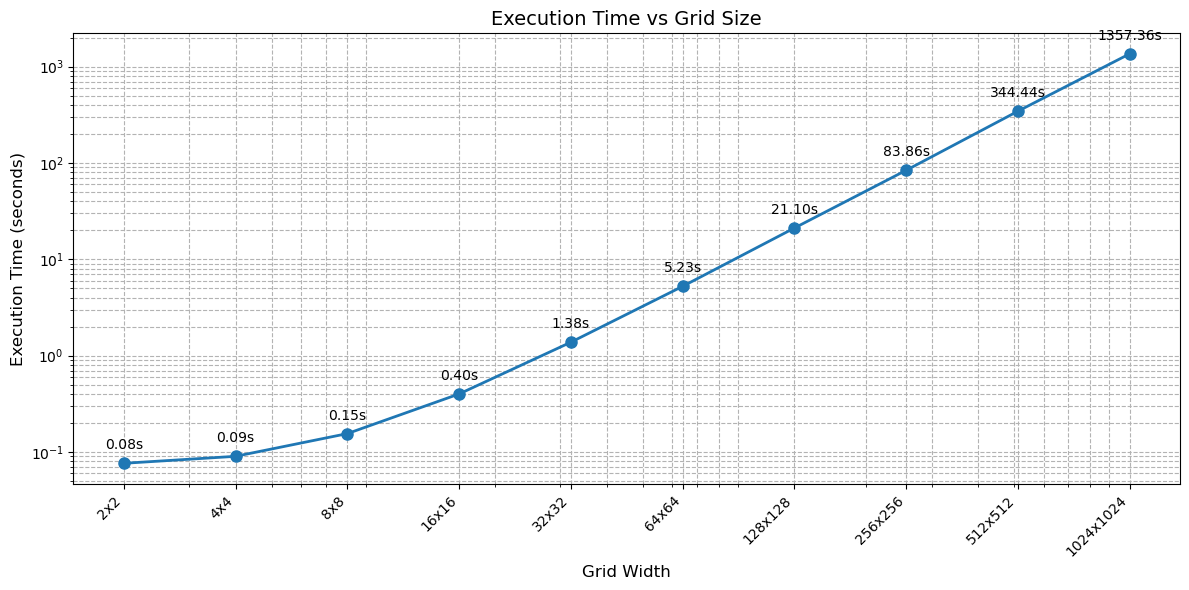

In [11]:
# Use the function
plot_execution_times(grid_sizes, execution_times)

In [12]:
def analyze_time_complexity(grid_sizes, execution_times):
    # Calculate input sizes (N = width * height)
    input_sizes = [size[0] * size[1] for size in grid_sizes]

    # Calculate logarithms
    log_sizes = np.log(input_sizes)
    log_times = np.log(execution_times)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_sizes, log_times)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original data plot
    ax1.plot(input_sizes, execution_times, 'bo-')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Input Size (N = width * height)')
    ax1.set_ylabel('Execution Time (seconds)')
    ax1.set_title('Execution Time vs Input Size')
    ax1.grid(True)

    # Log-log plot with regression line
    ax2.plot(log_sizes, log_times, 'ro', label='Data')
    ax2.plot(log_sizes, intercept + slope * log_sizes, 'b-', label=f'Fitted line (slope = {slope:.2f})')
    ax2.set_xlabel('log(Input Size)')
    ax2.set_ylabel('log(Execution Time)')
    ax2.set_title('Log-Log Plot with Regression Line')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Interpret results
    print(f"Estimated time complexity: O(N^{slope:.2f})")
    print(f"R-squared value: {r_value**2:.4f}")

    if abs(slope - 1) < 0.1:
        print("This suggests a linear time complexity, O(N)")
    elif abs(slope - 2) < 0.1:
        print("This suggests a quadratic time complexity, O(N^2)")
    elif abs(slope - np.log2(input_sizes[-1])/np.log2(input_sizes[0])) < 0.1:
        print("This suggests a logarithmic time complexity, O(log N)")
    elif abs(slope - (input_sizes[-1]*np.log2(input_sizes[-1]))/(input_sizes[0]*np.log2(input_sizes[0]))) < 0.1:
        print("This suggests a linearithmic time complexity, O(N log N)")
    else:
        print(f"This suggests a polynomial time complexity, O(N^{slope:.2f})")

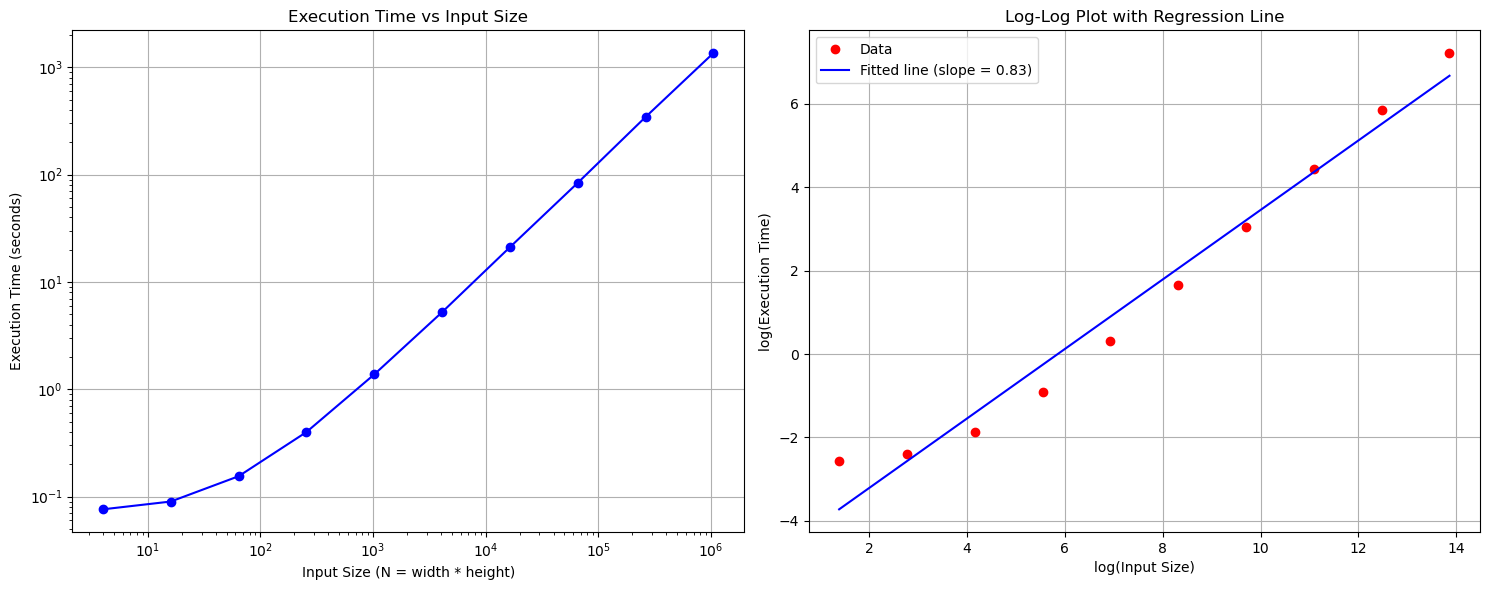

Estimated time complexity: O(N^0.83)
R-squared value: 0.9743
This suggests a polynomial time complexity, O(N^0.83)


In [13]:
# Use the function
analyze_time_complexity(grid_sizes, execution_times)



Interpretation:
Interestingly, this suggests that the algorithm is growing sublinearly with respect to the input size. This is actually better than linear time (O(N)) in terms of scalability.
Comparison:

Better than O(N) (linear time)

Better than O(N log N) (linearithmic time)

Much better than O(N^2) (quadratic time)

Worse than O(log N) (logarithmic time)

Worse than O(1) (constant time)